# 1. Import needed libraries

In [1]:
# ------------------------------
# 1. Import needed libraries
# ------------------------------

# ---------- Basic Python imports ----------
import os
import time
import warnings
# ---------- Image Processing ----------
from PIL import Image
# ---------- Data Analysis & Visualization ----------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# ---------- Machine Learning ----------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
# ---------- Deep Learning & TensorFlow ----------
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    BatchNormalization,
    Dense,
    Dropout,
    Conv2D,
    Multiply,
    GlobalAveragePooling2D,
    Reshape,
    Layer
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras import Input
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
# ---------- Settings ----------
warnings.filterwarnings("ignore")

In [2]:
# GPU/CPU detection
print("Checking available devices...")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"Physical GPUs: {len(gpus)}, Logical GPUs: {len(logical_gpus)}")
        strategy = tf.distribute.MirroredStrategy()
        print(f"Running on {len(strategy.extended.worker_devices)} GPU(s)")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        strategy = tf.distribute.get_strategy()
        print("Running on CPU")
else:
    strategy = tf.distribute.get_strategy()
    print("No GPU detected. Running on CPU")

print("REPLICAS: ", strategy.num_replicas_in_sync)

Checking available devices...
Physical GPUs: 1, Logical GPUs: 1
Running on 1 GPU(s)
REPLICAS:  1


# 2. Preprocessing

## 2.1 Load data

In [3]:
def create_dataset_df(path):
    """
    Create a DataFrame containing image paths and their corresponding classes.

    Args:
        path (str): Path to the dataset directory

    Returns:
        pd.DataFrame: DataFrame with columns 'Class Path' and 'Class'
    """
    classes, class_paths = zip(*[(label, os.path.join(path, label, image))
                                 for label in os.listdir(path) if os.path.isdir(os.path.join(path, label))
                                 for image in os.listdir(os.path.join(path, label))])

    return pd.DataFrame({'Class Path': class_paths, 'Class': classes})

In [4]:
tr_df = create_dataset_df('/kaggle/input/Training')

In [5]:
tr_df

Class Path      Class
0     /kaggle/input/Training/pituitary/Tr-pi_0532.jpg  pituitary
1     /kaggle/input/Training/pituitary/Tr-pi_0282.jpg  pituitary
2     /kaggle/input/Training/pituitary/Tr-pi_1401.jpg  pituitary
3     /kaggle/input/Training/pituitary/Tr-pi_0914.jpg  pituitary
4     /kaggle/input/Training/pituitary/Tr-pi_0691.jpg  pituitary
...                                               ...        ...
5707     /kaggle/input/Training/glioma/Tr-gl_0578.jpg     glioma
5708     /kaggle/input/Training/glioma/Tr-gl_0659.jpg     glioma
5709     /kaggle/input/Training/glioma/Tr-gl_0253.jpg     glioma
5710     /kaggle/input/Training/glioma/Tr-gl_0492.jpg     glioma
5711     /kaggle/input/Training/glioma/Tr-gl_1037.jpg     glioma

[5712 rows x 2 columns]

In [6]:
ts_df = create_dataset_df('/kaggle/input/Testing')

In [7]:
ts_df

Class Path      Class
0     /kaggle/input/Testing/pituitary/Te-pi_0059.jpg  pituitary
1     /kaggle/input/Testing/pituitary/Te-pi_0024.jpg  pituitary
2     /kaggle/input/Testing/pituitary/Te-pi_0232.jpg  pituitary
3     /kaggle/input/Testing/pituitary/Te-pi_0286.jpg  pituitary
4     /kaggle/input/Testing/pituitary/Te-pi_0233.jpg  pituitary
...                                              ...        ...
1306     /kaggle/input/Testing/glioma/Te-gl_0107.jpg     glioma
1307     /kaggle/input/Testing/glioma/Te-gl_0288.jpg     glioma
1308     /kaggle/input/Testing/glioma/Te-gl_0108.jpg     glioma
1309   /kaggle/input/Testing/glioma/Te-glTr_0004.jpg     glioma
1310     /kaggle/input/Testing/glioma/Te-gl_0250.jpg     glioma

[1311 rows x 2 columns]

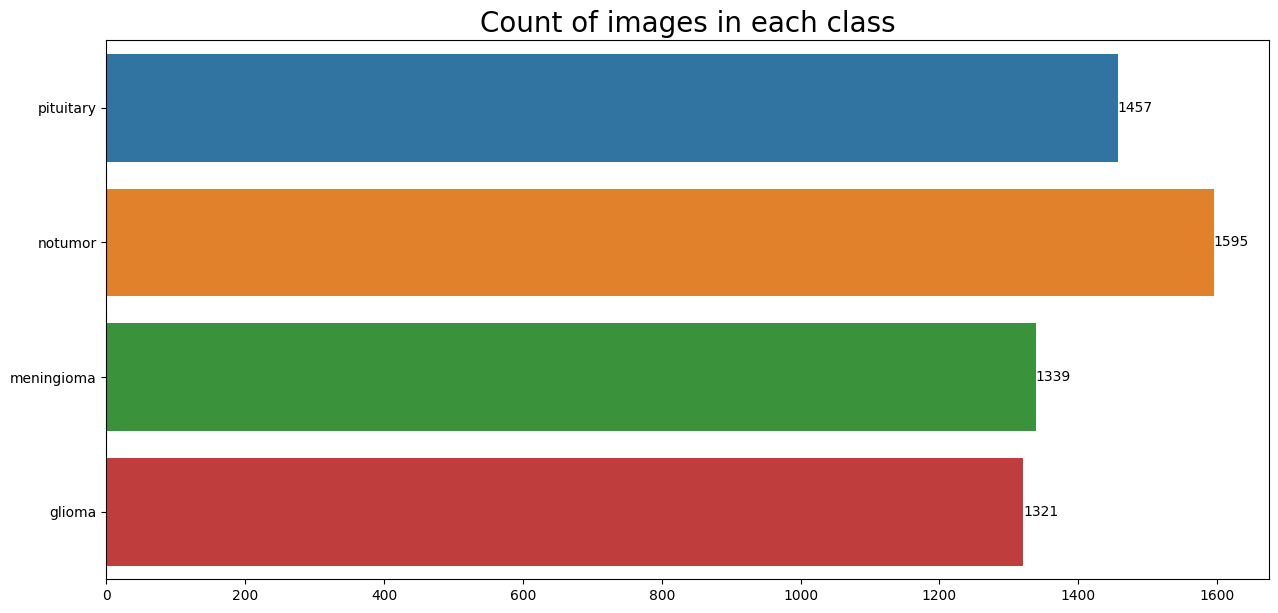

In [8]:
# Count of images in each class in train data
plt.figure(figsize=(15, 7))
ax = sns.countplot(data=tr_df, y=tr_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])

plt.show()

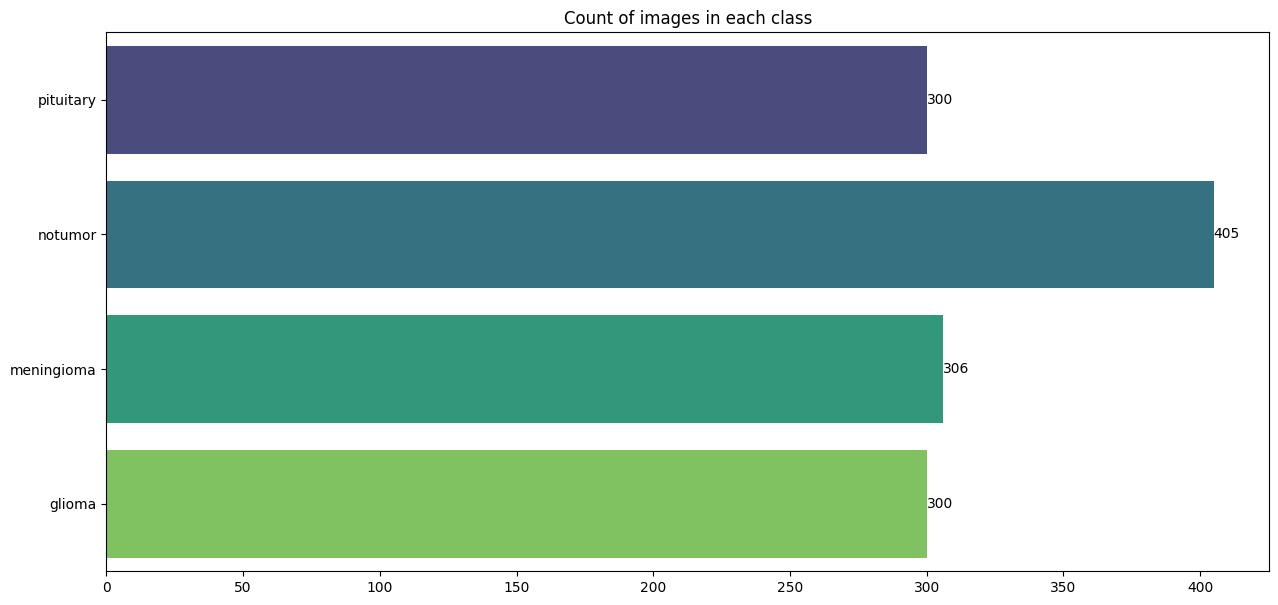

In [9]:
# Count each class in test data
plt.figure(figsize=(15, 7))
ax = sns.countplot(y=ts_df['Class'], palette='viridis')

ax.set(xlabel='', ylabel='', title='Count of images in each class')
ax.bar_label(ax.containers[0])

plt.show()

## 2.2 Split data into train, test, valid

In [10]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class'])

In [11]:
valid_df

Class Path       Class
1297      /kaggle/input/Testing/glioma/Te-gl_0227.jpg      glioma
723   /kaggle/input/Testing/meningioma/Te-me_0269.jpg  meningioma
61     /kaggle/input/Testing/pituitary/Te-pi_0210.jpg   pituitary
778   /kaggle/input/Testing/meningioma/Te-me_0013.jpg  meningioma
1120    /kaggle/input/Testing/glioma/Te-glTr_0008.jpg      glioma
...                                               ...         ...
1070      /kaggle/input/Testing/glioma/Te-gl_0293.jpg      glioma
554      /kaggle/input/Testing/notumor/Te-no_0054.jpg     notumor
1284      /kaggle/input/Testing/glioma/Te-gl_0298.jpg      glioma
899   /kaggle/input/Testing/meningioma/Te-me_0297.jpg  meningioma
626      /kaggle/input/Testing/notumor/Te-no_0351.jpg     notumor

[655 rows x 2 columns]

## 2.3 Data Augmentation and Generators (Data Preprocessing)

In [12]:
BATCH_SIZE = 32 * strategy.num_replicas_in_sync
IMAGE_SIZE = (224, 224)


def prepare_data(tr_df, ts_df):
    def process_image(file_path):
        img = Image.open(file_path)
        # Convert grayscale to RGB if needed
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img = img.resize(IMAGE_SIZE)
        return np.array(img)

    # Convert DataFrame to numpy arrays
    X = np.array([process_image(f)
                 for f in tr_df['Class Path']], dtype=np.float32) / 255.0
    y = pd.get_dummies(tr_df['Class']).values

    X_test = np.array([process_image(f)
                      for f in ts_df['Class Path']], dtype=np.float32) / 255.0
    y_test = pd.get_dummies(ts_df['Class']).values

    return X, y, X_test, y_test


def get_augmentation():
    return ImageDataGenerator(
        rescale=1/255,
        brightness_range=(0.9, 1.1),
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='reflect'
    )


_gen = get_augmentation()

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=BATCH_SIZE,
                                  target_size=IMAGE_SIZE)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=BATCH_SIZE,
                                     target_size=IMAGE_SIZE)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                    y_col='Class', batch_size=BATCH_SIZE,
                                    target_size=IMAGE_SIZE, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


## 2.4 Getting samples from data

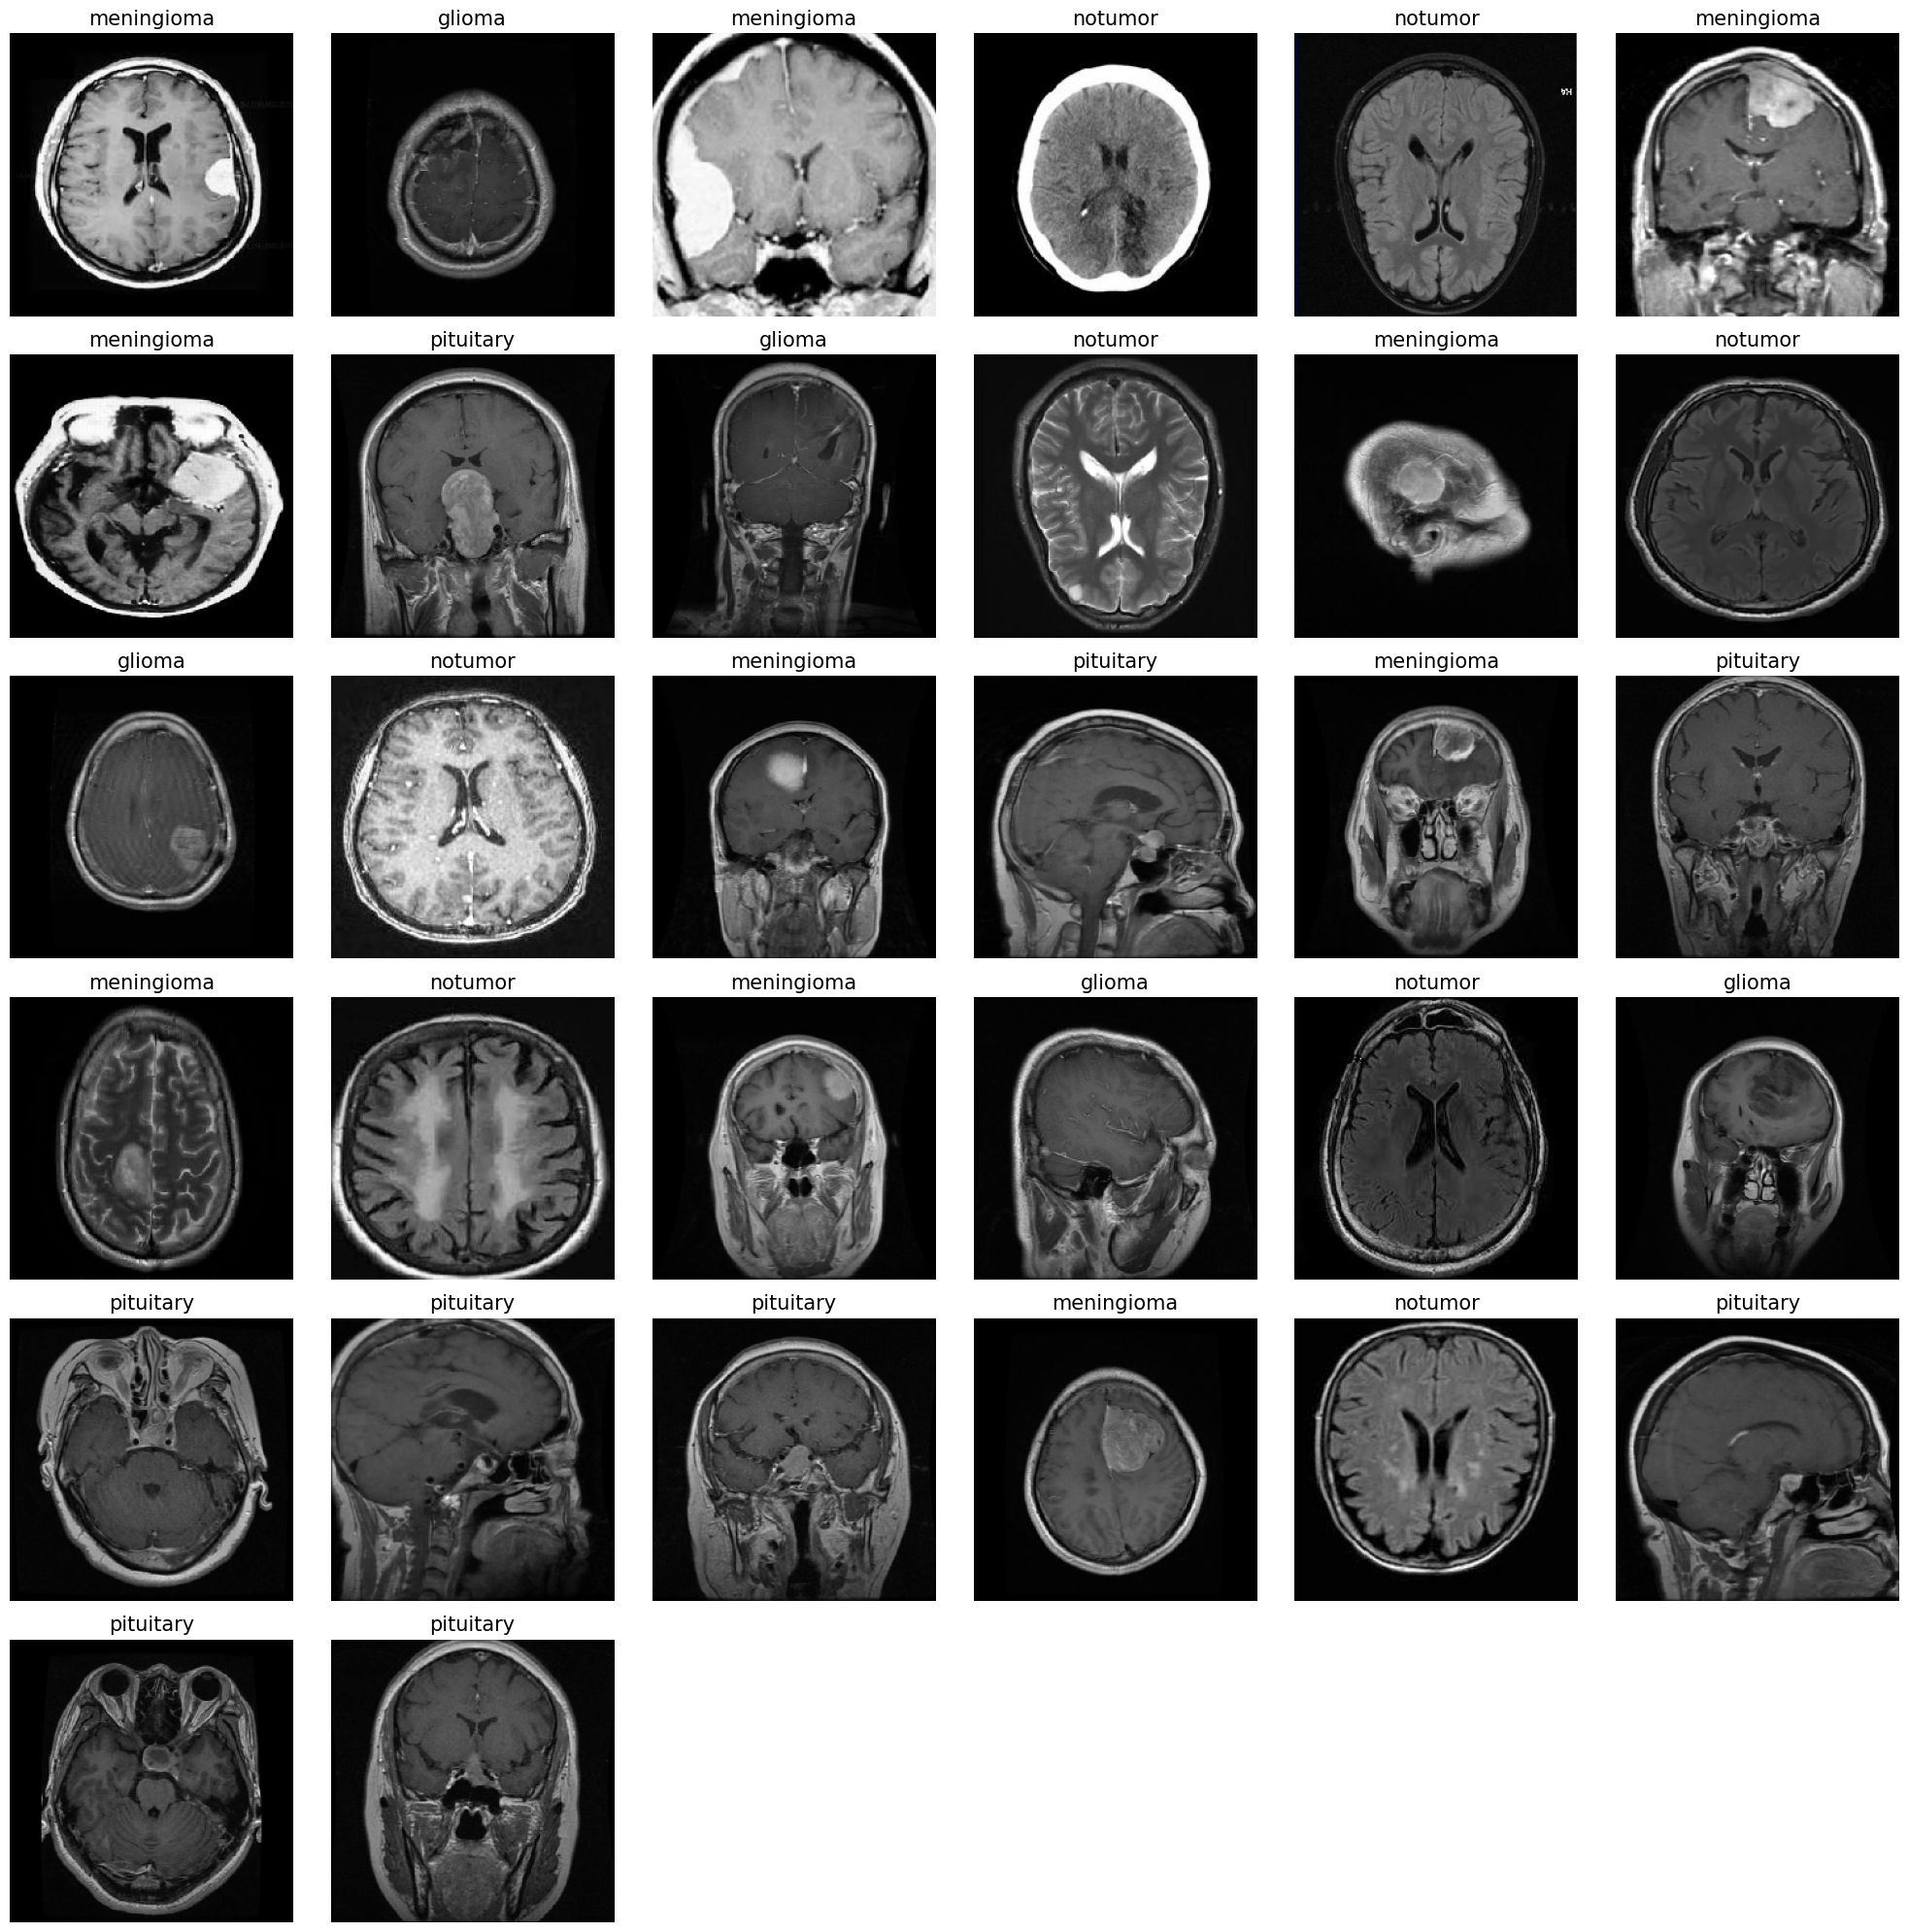

In [13]:
# Get the class dictionary and classes list
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())

# Get a batch of images
images, labels = next(ts_gen)

# Calculate grid dimensions based on number of images
n_images = len(images)
grid_size = int(np.ceil(np.sqrt(n_images)))  # Make a square grid

# Create the plot
plt.figure(figsize=(20, 20))

# Show all images in a dynamic grid (uncomment to use)
for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(grid_size, grid_size, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)
    plt.axis('off')

plt.tight_layout()
plt.show()

# 3. Building Deep Learning Model

In [14]:
class SAM(Model):
    def __init__(self, filters):
        super(SAM, self).__init__()
        self.filters = filters
        # Three sequential 3x3 convs as specified
        self.conv1 = Conv2D(self.filters // 4, 3, activation='relu',
                            padding='same', kernel_initializer='he_normal')
        self.conv2 = Conv2D(self.filters // 4, 3, activation='relu',
                            padding='same', kernel_initializer='he_normal')
        self.conv3 = Conv2D(self.filters // 4, 3, activation='relu',
                            padding='same', kernel_initializer='he_normal')
        # Dimension reduction conv
        self.conv4 = Conv2D(self.filters // 4, 1,
                            activation='relu', kernel_initializer='he_normal')
        # Attention branch convs
        self.W1 = Conv2D(1, 1, activation='sigmoid',
                         kernel_initializer='he_normal')
        self.W2 = Conv2D(1, 1, activation='sigmoid',
                         kernel_initializer='he_normal')

    def call(self, inputs):
        # Sequential convolutions
        out1 = self.conv3(self.conv2(self.conv1(inputs)))
        # Dimension reduction
        out2 = self.conv4(inputs)

        # 2x2 max pooling branch
        pool1 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(out2)
        # Bilinear upsampling to original size
        upsample1 = tf.image.resize(pool1, size=tf.shape(out2)[
                                    1:3], method='bilinear')
        # Apply 1x1 conv with sigmoid
        attention1 = self.W1(upsample1)

        # 4x4 max pooling branch
        pool2 = tf.keras.layers.MaxPool2D(pool_size=(4, 4))(out2)
        # Bilinear upsampling to original size
        upsample2 = tf.image.resize(pool2, size=tf.shape(out2)[
                                    1:3], method='bilinear')
        # Apply 1x1 conv with sigmoid
        attention2 = self.W2(upsample2)

        # Sum the two attention maps
        attention_sum = attention1 + attention2

        # Apply attention to features via element-wise multiplication
        attended_features = Multiply()([out1, attention_sum])

        # Add to dimension-reduced input (residual connection)
        y = attended_features + out2
        return y


class CAM(Model):
    def __init__(self, filters, reduction_ratio=16):
        super(CAM, self).__init__()
        self.filters = filters
        # Conv block to process input features
        self.conv1 = Conv2D(self.filters // 4, 3, activation='relu',
                            padding='same', kernel_initializer='he_normal')
        self.conv2 = Conv2D(self.filters // 4, 3, activation='relu',
                            padding='same', kernel_initializer='he_normal')
        self.conv3 = Conv2D(self.filters // 4, 3, activation='relu',
                            padding='same', kernel_initializer='he_normal')
        # Dimension reduction conv
        self.conv4 = Conv2D(self.filters // 4, 1,
                            activation='relu', kernel_initializer='he_normal')
        # Squeeze-and-Excitation components
        self.gpool = GlobalAveragePooling2D()
        self.fc1 = Dense(self.filters // (4 * reduction_ratio),
                         activation='relu', use_bias=False)
        self.fc2 = Dense(self.filters // 4,
                         activation='sigmoid', use_bias=False)

    def call(self, inputs):
        # Process input through conv block
        out1 = self.conv3(self.conv2(self.conv1(inputs)))
        # Dimension reduction
        out2 = self.conv4(inputs)

        # Squeeze-and-Excitation: squeeze spatial dimensions
        channel_attention = self.gpool(out2)
        # Dimension reduction in channel-wise fully connected layer
        channel_attention = self.fc1(channel_attention)
        # Dimension increase with sigmoid activation
        channel_attention = self.fc2(channel_attention)
        # Reshape to proper dimensions for broadcasting
        channel_attention = Reshape(
            (1, 1, self.filters // 4))(channel_attention)

        # Apply channel attention via element-wise multiplication
        recalibrated = Multiply()([out1, channel_attention])

        # Add residual connection with dimension-reduced input
        y = recalibrated + out2
        return y


class SynergyModule(Model):
    def __init__(self, filters):
        super(SynergyModule, self).__init__()
        self.filters = filters
        # Trainable scaling parameters
        self.alpha = tf.Variable(
            0.5, trainable=True, dtype=tf.float32, name="alpha")
        self.beta = tf.Variable(0.5, trainable=True,
                                dtype=tf.float32, name="beta")
        # Integration components
        self.conv = Conv2D(filters, 3, padding='same',
                           kernel_initializer='he_normal')
        self.bn = BatchNormalization()

    def call(self, inputs):
        # Unpack inputs (spatial and channel attention outputs)
        spatial_features, channel_features = inputs

        # Scale each pathway with trainable parameters
        scaled_spatial = tf.multiply(spatial_features, self.alpha)
        scaled_channel = tf.multiply(channel_features, self.beta)

        # Sum the scaled features
        combined = scaled_spatial + scaled_channel

        # Apply convolution and batch normalization
        output = self.conv(combined)
        output = self.bn(output)

        return output


class ResizeLayer(Layer):
    def __init__(self, target_height, target_width, **kwargs):
        super(ResizeLayer, self).__init__(**kwargs)
        self.target_height = target_height
        self.target_width = target_width

    def call(self, inputs):
        return tf.image.resize(inputs, (self.target_height, self.target_width))


def adjust_feature_map(x, target_shape):
    _, h, w, _ = target_shape
    current_h, current_w = x.shape[1:3]
    if current_h != h or current_w != w:
        resize_layer = ResizeLayer(h, w)
        return resize_layer(x)
    return x


# AS_Net with EfficientNetV2B0 encoder
def AS_Net(encoder='efficientnet', input_size=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), fine_tune_at=None):
    inputs = Input(input_size)
    print(f'CURRENT ENCODER: {encoder}')

    if encoder == 'efficientnet':
        # Load EfficientNetV2B0 with ImageNet weights
        ENCODER = EfficientNetV2B0(weights='imagenet', include_top=False,
                        input_shape=input_size)

        # Freeze all layers initially
        ENCODER.trainable = False

        # Optionally, unfreeze layers for fine-tuning from a certain layer
        if fine_tune_at is not None:
            for layer in ENCODER.layers[:fine_tune_at]:
                layer.trainable = False
            for layer in ENCODER.layers[fine_tune_at:]:
                layer.trainable = True

        # Selected output layers (you can experiment with different indices)
        layer_indices = [2, 5, 9, 13, 17]
    else:
        raise ValueError(
            "Unsupported encoder type. Only 'efficientnet' is supported in this case.")

    # Get the output layers dynamically
    output_layers = [ENCODER.get_layer(index=i).output for i in layer_indices]
    encoder_outputs = [Model(inputs=ENCODER.inputs, outputs=layer)(inputs)
                       for layer in output_layers]

    # Get the final encoder output that will be processed by the attention paths
    final_encoder_output = encoder_outputs[-1]
    filters = final_encoder_output.shape[-1]

    # Create two parallel attention paths
    # Spatial Attention Path
    SAM_output = SAM(filters=filters)(final_encoder_output)

    # Channel Attention Path
    CAM_output = CAM(filters=filters)(final_encoder_output)

    # Apply Synergy Module to combine attention outputs
    synergy_output = SynergyModule(filters=filters)([SAM_output, CAM_output])

    # Simplify the final layers
    final_layers = Sequential([
        Conv2D(128, 3, activation='relu', padding='same'),
        BatchNormalization(),
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(4, activation='softmax')
    ])

    output = final_layers(synergy_output)

    model = Model(inputs=inputs, outputs=output)
    return model


# Create and compile the model
with strategy.scope():
    model = AS_Net(encoder='efficientnet', fine_tune_at=12)

    # Simplified learning rate setup
    initial_learning_rate = 1e-4

    optimizer = Adam(learning_rate=initial_learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )

model.summary()

CURRENT ENCODER: efficientnet
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_4 (Functional) │ (None, 56, 56, 32)     │         58,784 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sam (SAM)                 │ (None, 56, 56, 8)      │          3,762 │ functional_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cam (CAM)                 │ (None, 56, 56, 8)      │          3,744 │ functional_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ synergy_module            │ (None, 56, 56, 32)     │          2,464 │ sam[0][0], cam[0][0]   │
│ (SynergyModule)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 4)              │         71,556 │ synergy_module[0][0]   │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 140,310 (548.09 KB)

 Trainable params: 124,534 (486.46 KB)

 Non-trainable params: 15,776 (61.62 KB)

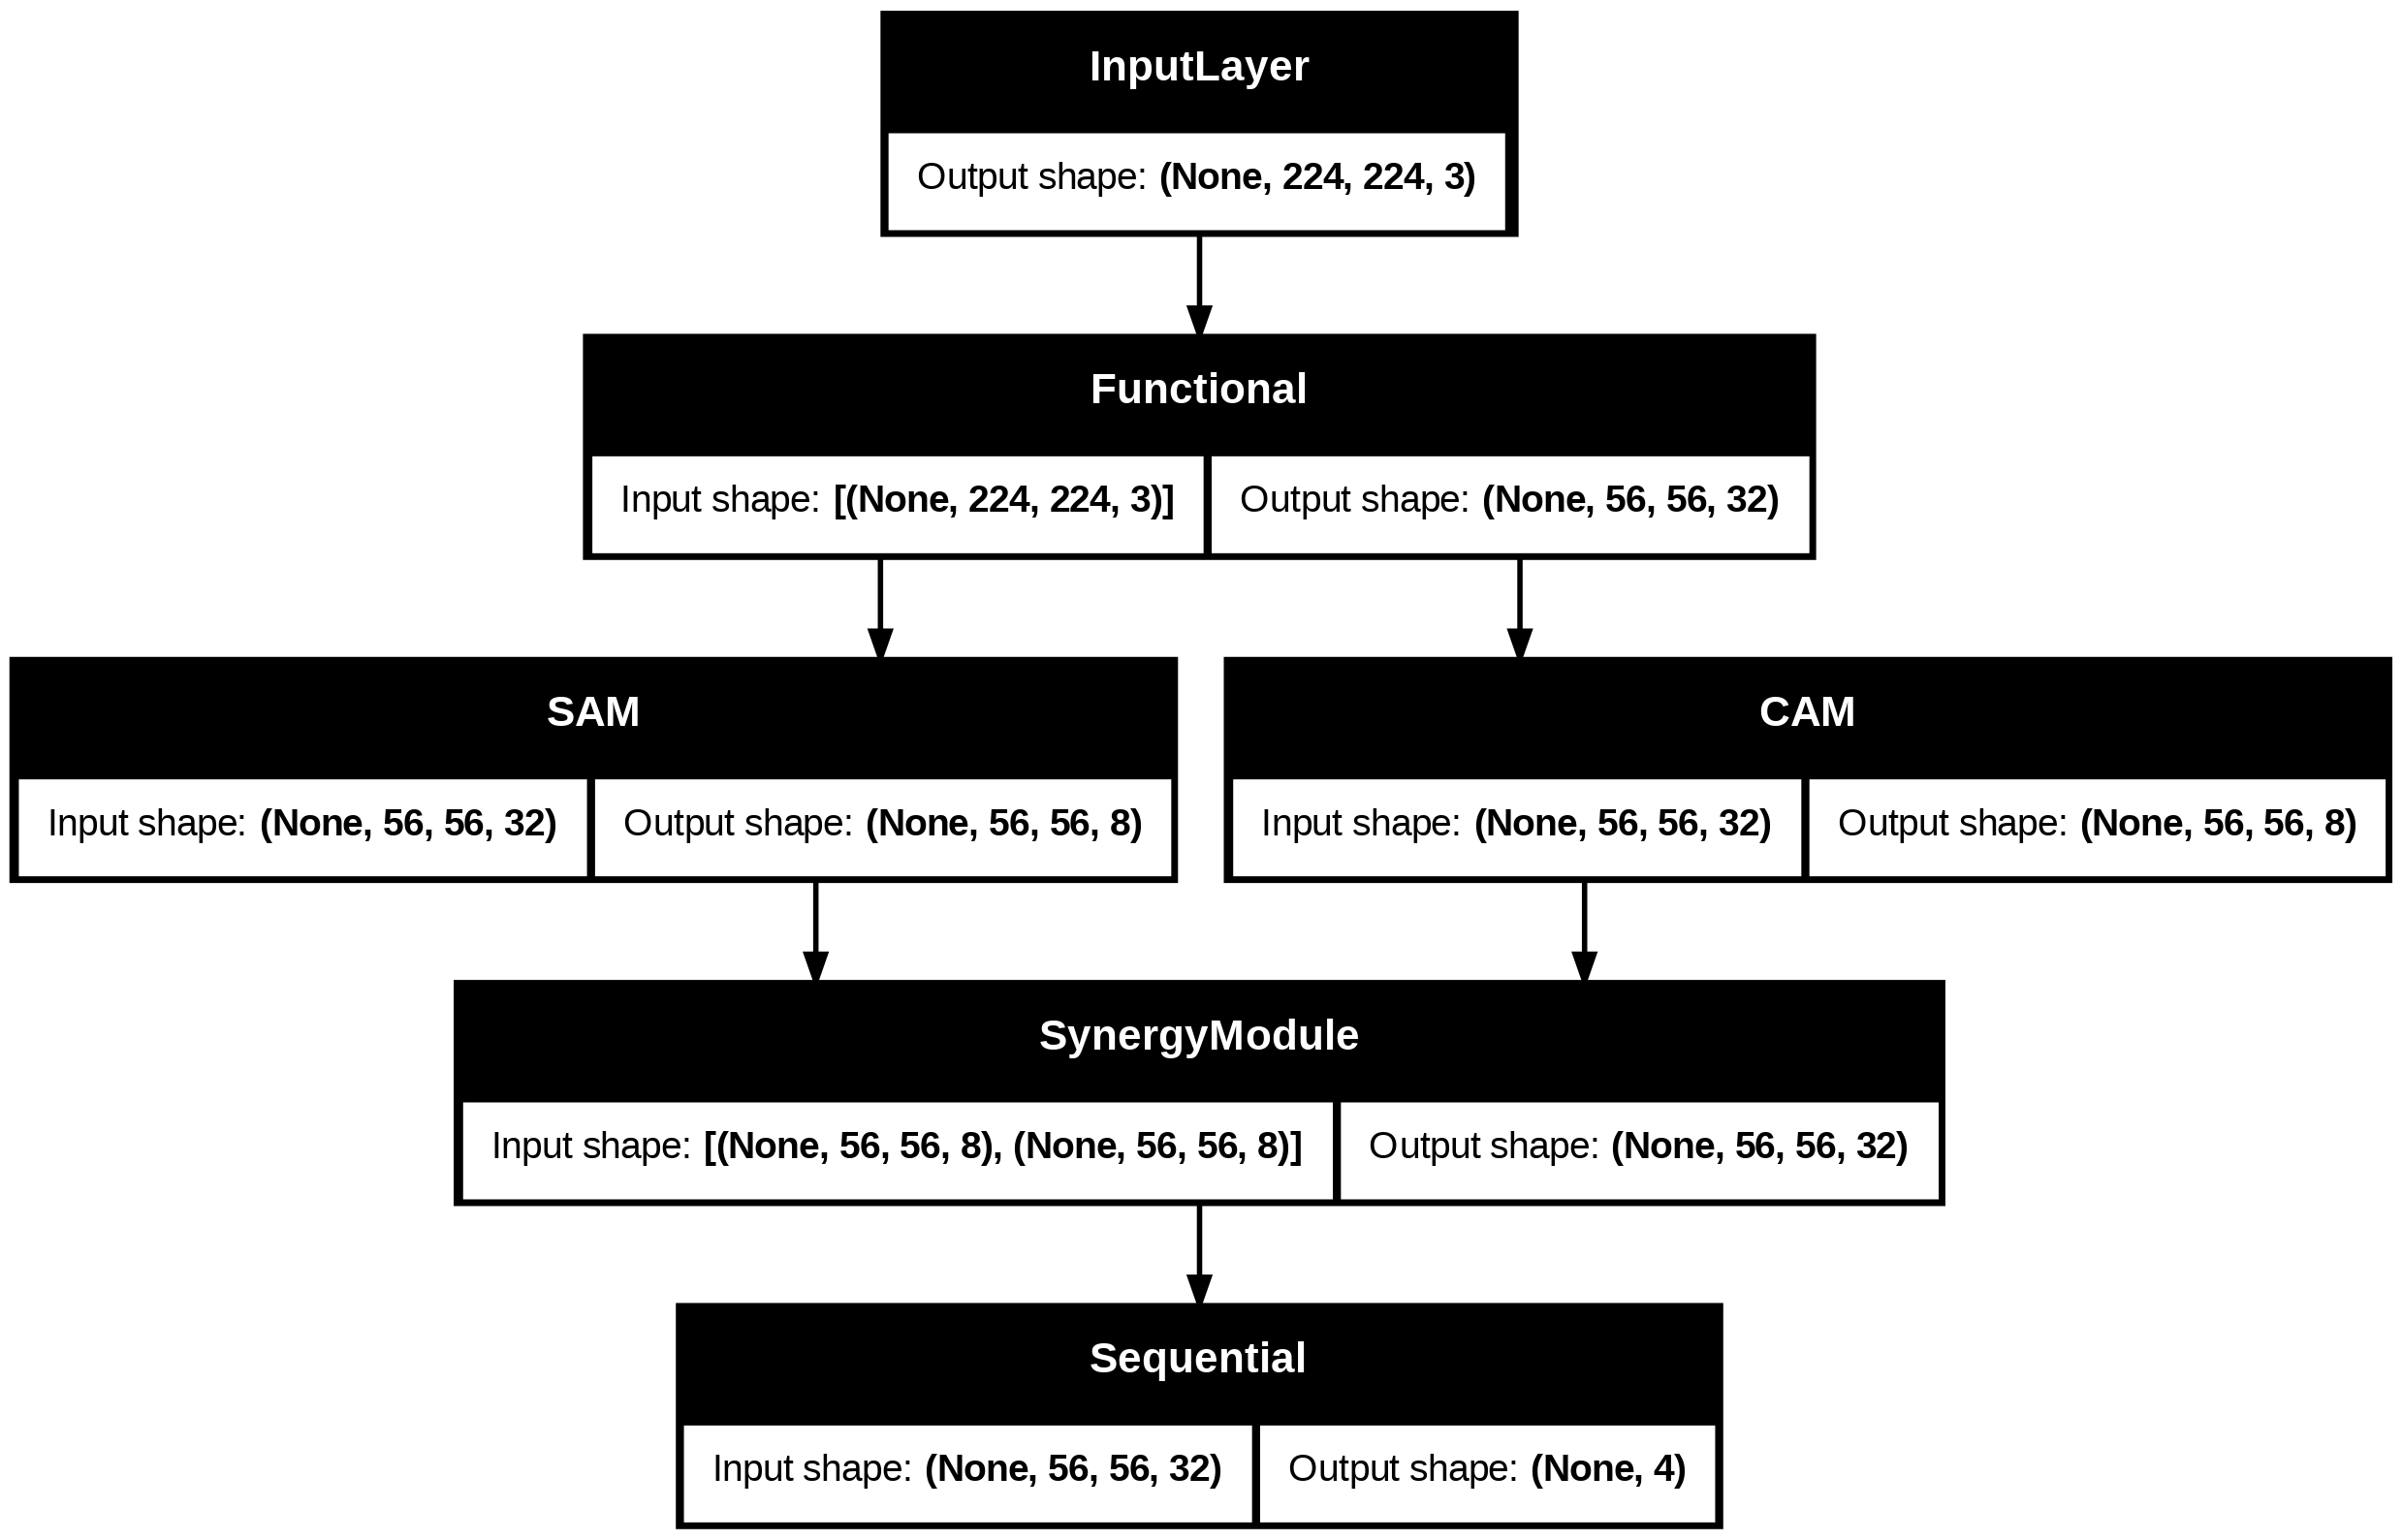

In [15]:
tf.keras.utils.plot_model(model, show_shapes=True)

# 4. Training

In [16]:
start_time = time.time()
num_epochs = 35

# Callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs',
    histogram_freq=1,
    write_graph=True,
    profile_batch=0
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)


# Compute class weights
def get_class_weights(y):
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y),
        y=y
    )
    return dict(enumerate(class_weights))


# Calculate balanced class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(tr_gen.classes),
    y=tr_gen.classes
)

class_weight_dict = dict(enumerate(class_weights))

# Use in training
hist = model.fit(
    tr_gen,
    epochs=num_epochs,
    validation_data=valid_gen,
    shuffle=True,
    class_weight=class_weight_dict,  # Use computed class weights
    callbacks=[
        early_stopping,
        tensorboard_callback,
        reduce_lr,
        checkpoint
    ]
)

Epoch 1/35
179/179 ━━━━━━━━━━━━━━━━━━━━ 131s 655ms/step - accuracy: 0.4701 - auc: 0.7457 - loss: 1.1921 - precision: 0.8380 - recall: 0.1489 - val_accuracy: 0.3099 - val_auc: 0.6499 - val_loss: 1.5171 - val_precision: 0.3404 - val_recall: 0.2931 - learning_rate: 1.0000e-04
Epoch 2/35
179/179 ━━━━━━━━━━━━━━━━━━━━ 97s 521ms/step - accuracy: 0.6894 - auc: 0.8882 - loss: 0.8258 - precision: 0.7879 - recall: 0.5241 - val_accuracy: 0.6107 - val_auc: 0.8528 - val_loss: 0.9087 - val_precision: 0.7383 - val_recall: 0.4824 - learning_rate: 1.0000e-04
Epoch 3/35
179/179 ━━━━━━━━━━━━━━━━━━━━ 95s 512ms/step - accuracy: 0.7172 - auc: 0.9097 - loss: 0.7438 - precision: 0.7895 - recall: 0.6149 - val_accuracy: 0.3710 - val_auc: 0.7126 - val_loss: 1.8787 - val_precision: 0.3829 - val_recall: 0.3618 - learning_rate: 1.0000e-04
Epoch 4/35
179/179 ━━━━━━━━━━━━━━━━━━━━ 96s 518ms/step - accuracy: 0.7384 - auc: 0.9208 - loss: 0.6956 - precision: 0.7948 - recall: 0.6543 - val_accuracy: 0.6366 - val_auc: 0.8861

In [17]:
end_time = time.time()
training_duration = end_time - start_time

# Print duration in hours, minutes, and seconds
hours = int(training_duration // 3600)
minutes = int((training_duration % 3600) // 60)
seconds = int(training_duration % 60)
print(f"\nTotal training time: {hours:02d}:{minutes:02d}:{seconds:02d}")


Total training time: 00:31:56


In [18]:
hist.history.keys()

dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])

## 4.1 Visualize model performance

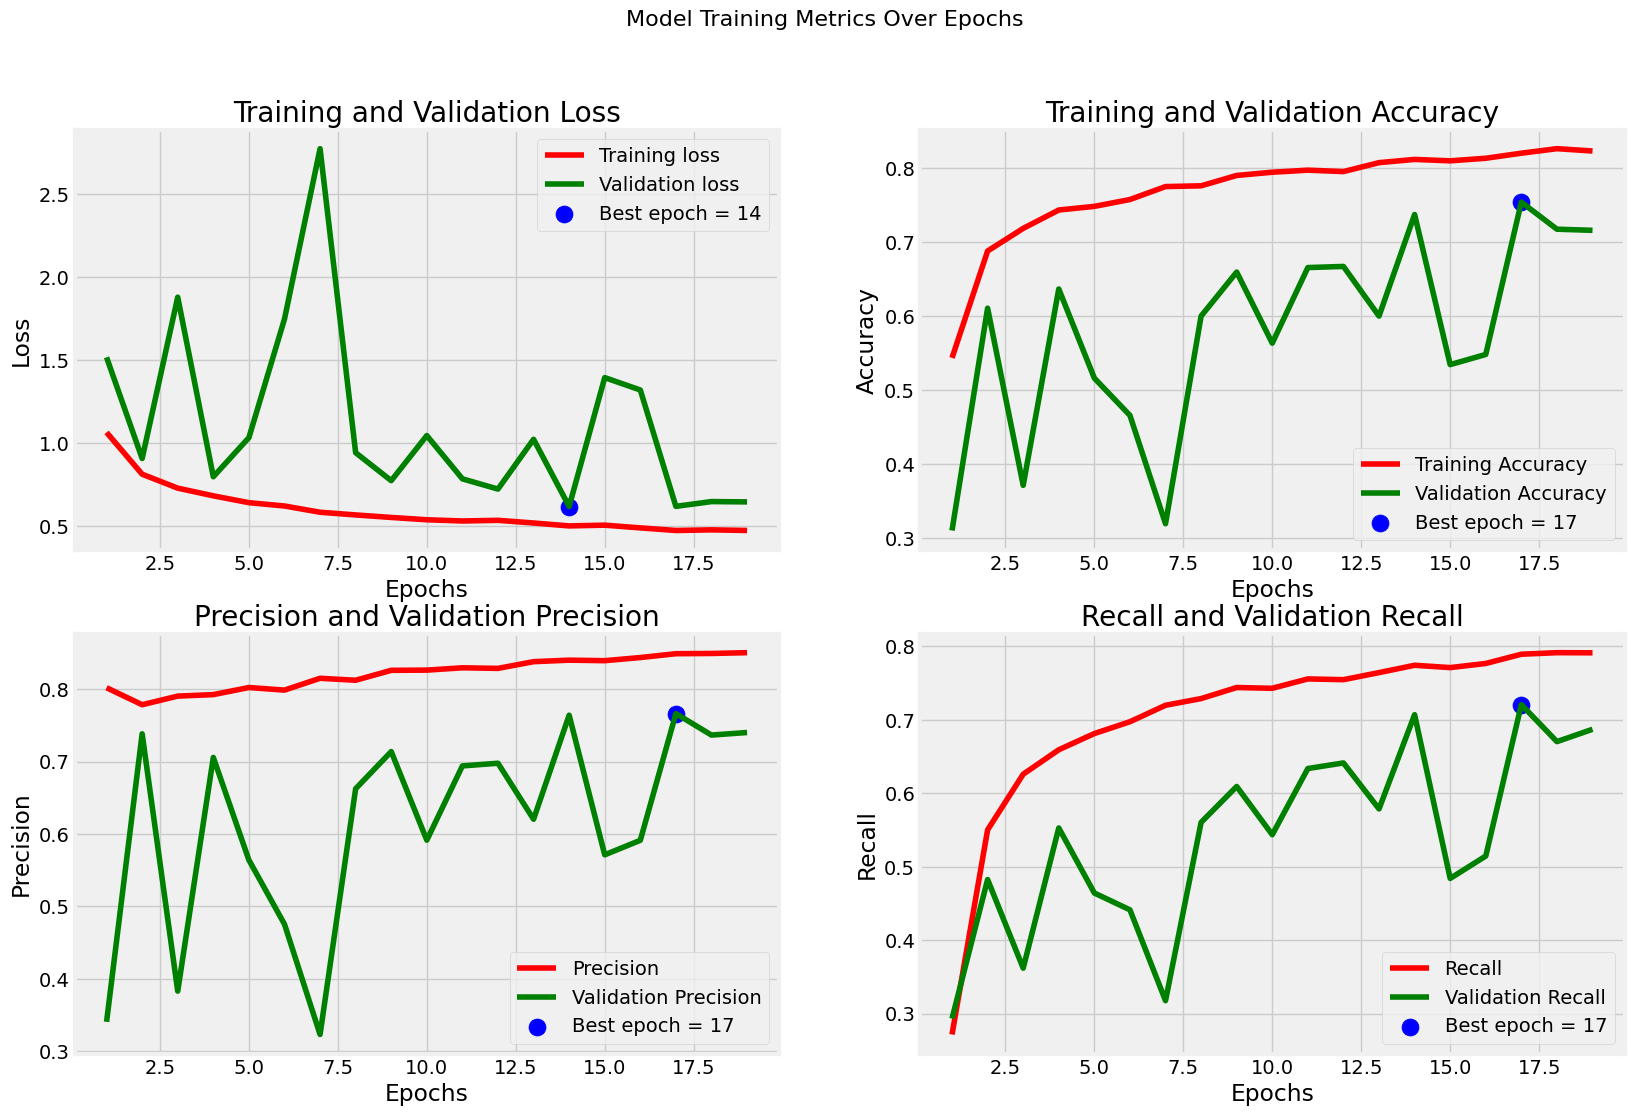

In [19]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision']
tr_recall = hist.history['recall']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision']
val_recall = hist.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest,
            s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

# 5. Testing and Evaluation

## 5.1 Evaluate

In [20]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

179/179 ━━━━━━━━━━━━━━━━━━━━ 88s 489ms/step - accuracy: 0.8295 - auc: 0.9616 - loss: 0.4675 - precision: 0.8561 - recall: 0.7909
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 463ms/step - accuracy: 0.7194 - auc: 0.9221 - loss: 0.6924 - precision: 0.7494 - recall: 0.6968
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step - accuracy: 0.7843 - auc: 0.9448 - loss: 0.5571 - precision: 0.8164 - recall: 0.7406
Train Loss: 0.4736
Train Accuracy: 82.32%
--------------------
Validation Loss: 0.5875
Validation Accuracy: 75.73%
--------------------
Test Loss: 0.5536
Test Accuracy: 78.66%


In [21]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step


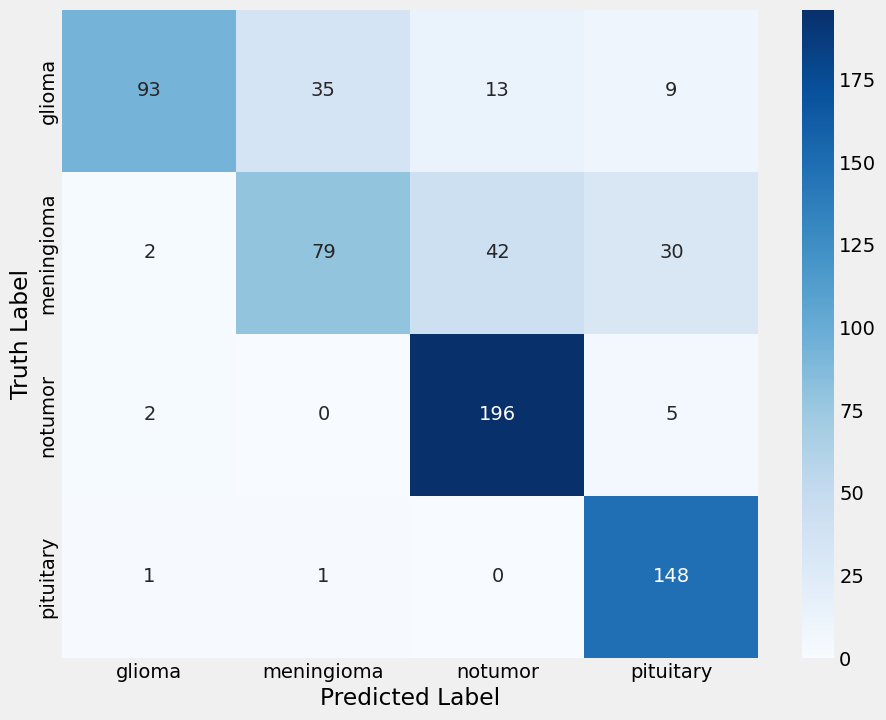

In [22]:
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

clr = classification_report(ts_gen.classes, y_pred)
print(clr)

## 5.2 Testing

In [24]:
# Prediction function with TTA
def predict_with_tta(model, img_path, num_augmentations=5):
    img = Image.open(img_path)
    resized_img = img.resize(IMAGE_SIZE)
    img_array = np.asarray(resized_img)

    # Create augmented versions
    predictions = []
    aug = get_augmentation()

    # Original prediction
    base_pred = model.predict(np.expand_dims(img_array, 0)/255.0)
    predictions.append(base_pred)

    # Augmented predictions
    for _ in range(num_augmentations):
        aug_img = aug.random_transform(img_array)
        aug_pred = model.predict(np.expand_dims(aug_img, 0)/255.0)
        predictions.append(aug_pred)

    # Average predictions
    return np.mean(predictions, axis=0)


def predict(img_path):
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize(IMAGE_SIZE)

    # Use TTA for prediction
    predictions = predict_with_tta(model, img_path)
    probs = list(predictions[0])
    labels = label

    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt='%.2f')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


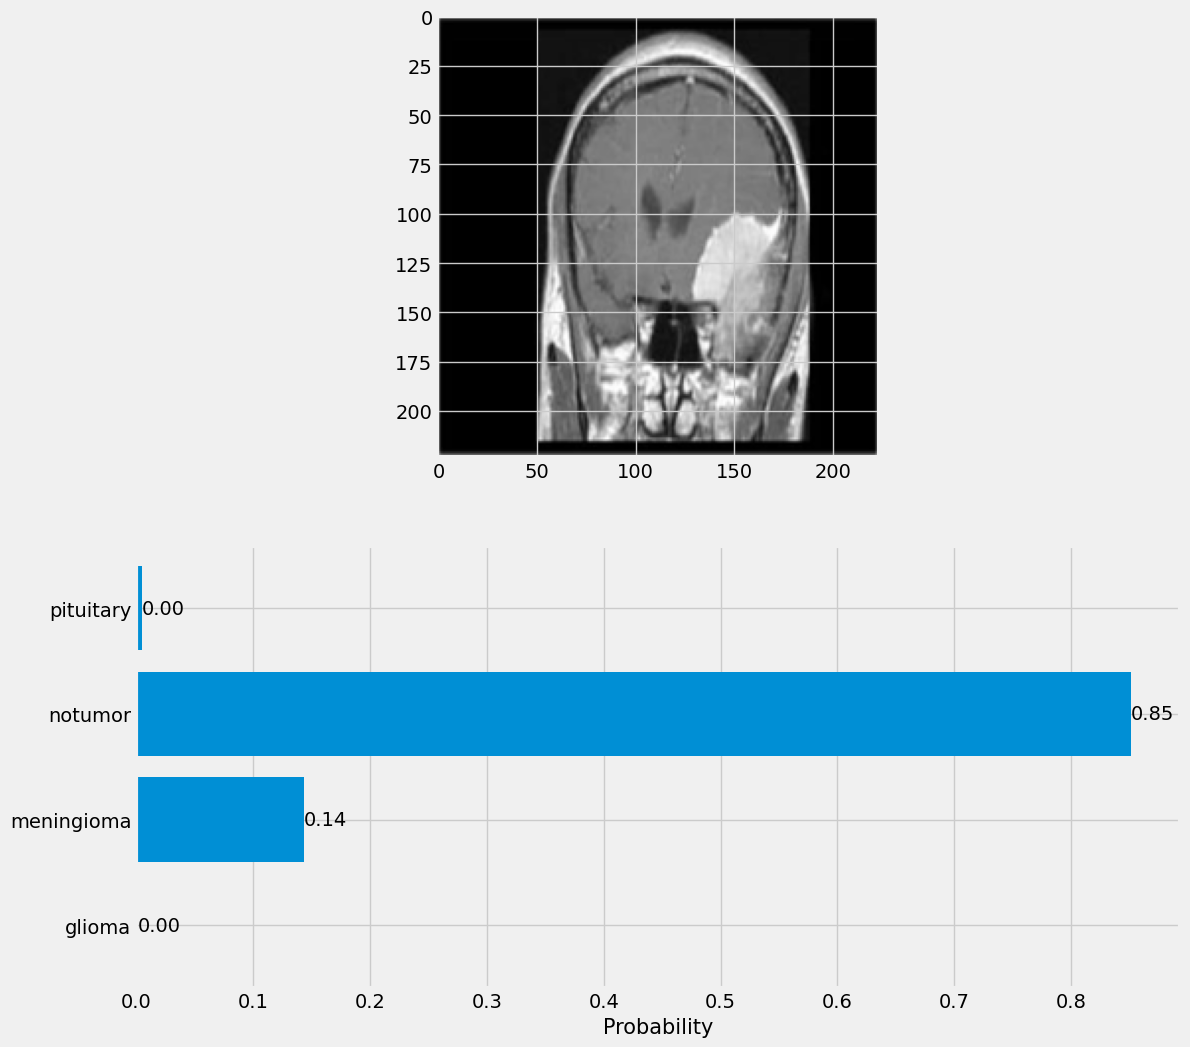

In [25]:
predict('/kaggle/input/Testing/meningioma/Te-meTr_0000.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


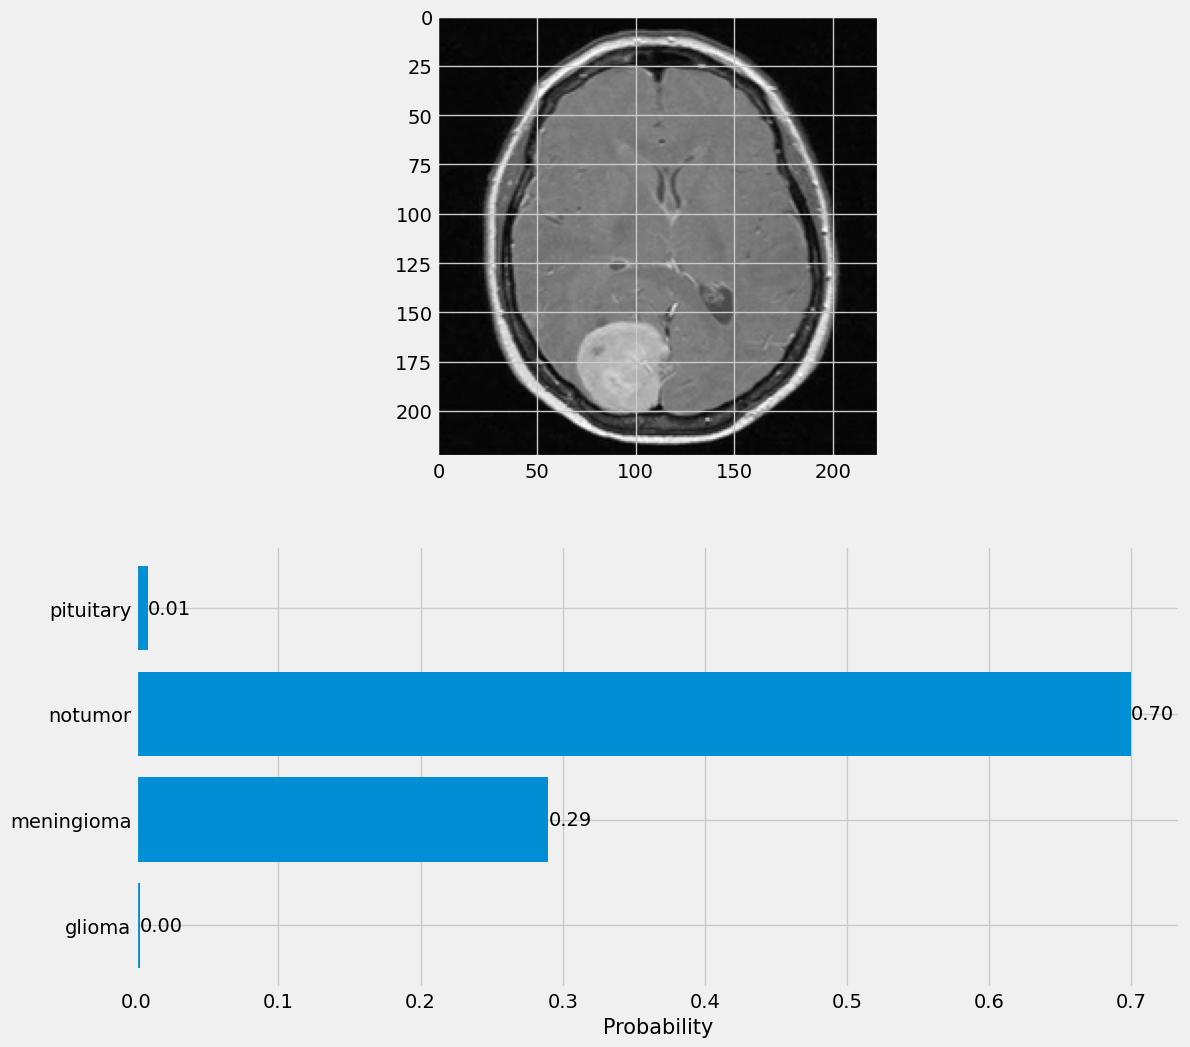

In [26]:
predict('/kaggle/input/Testing/meningioma/Te-me_0010.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


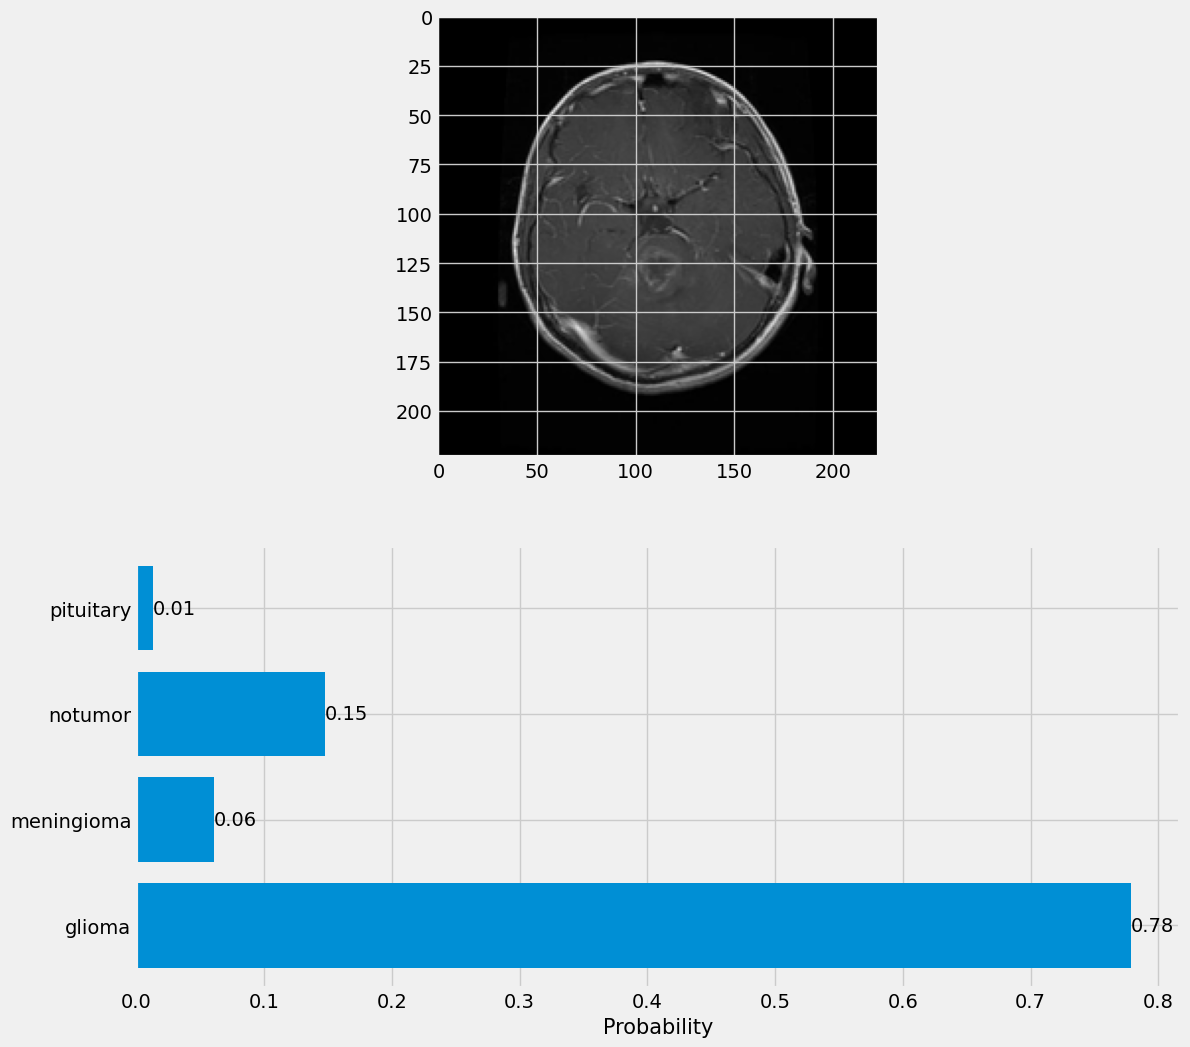

In [27]:
predict('/kaggle/input/Testing/glioma/Te-glTr_0007.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


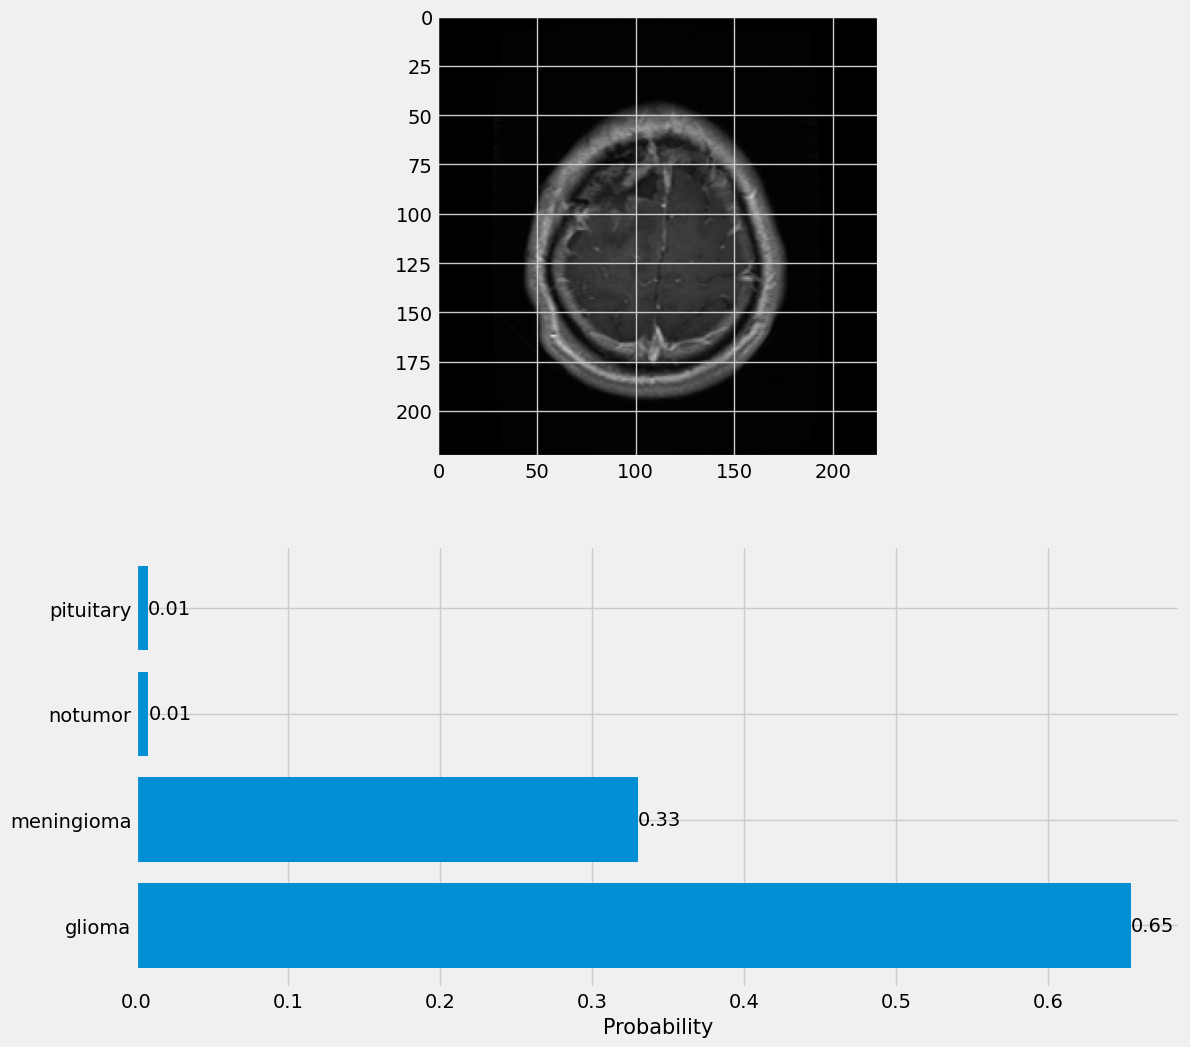

In [28]:
predict('/kaggle/input/Testing/glioma/Te-gl_0017.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


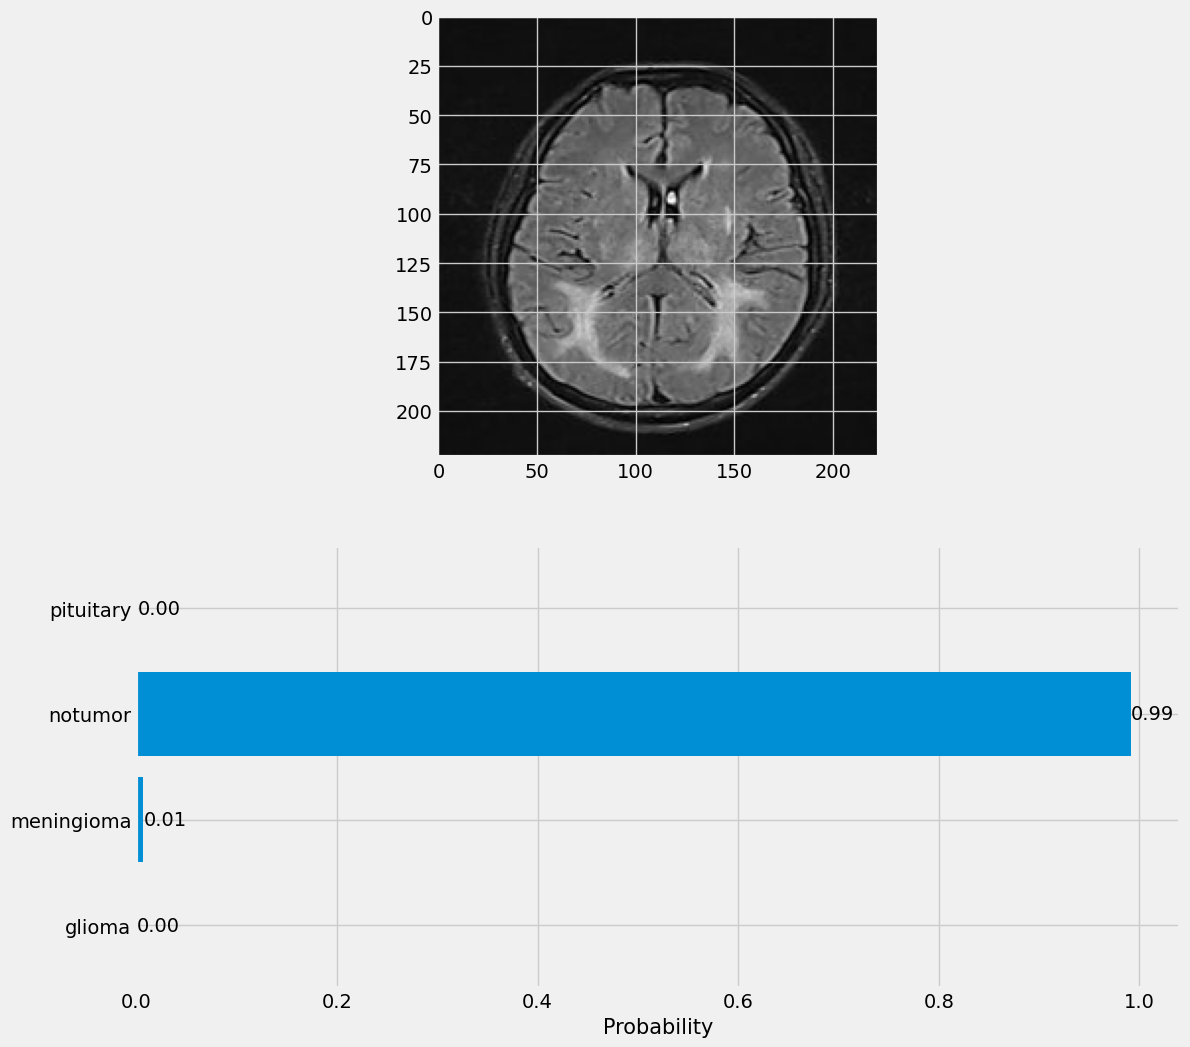

In [29]:
predict('/kaggle/input/Testing/notumor/Te-noTr_0001.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


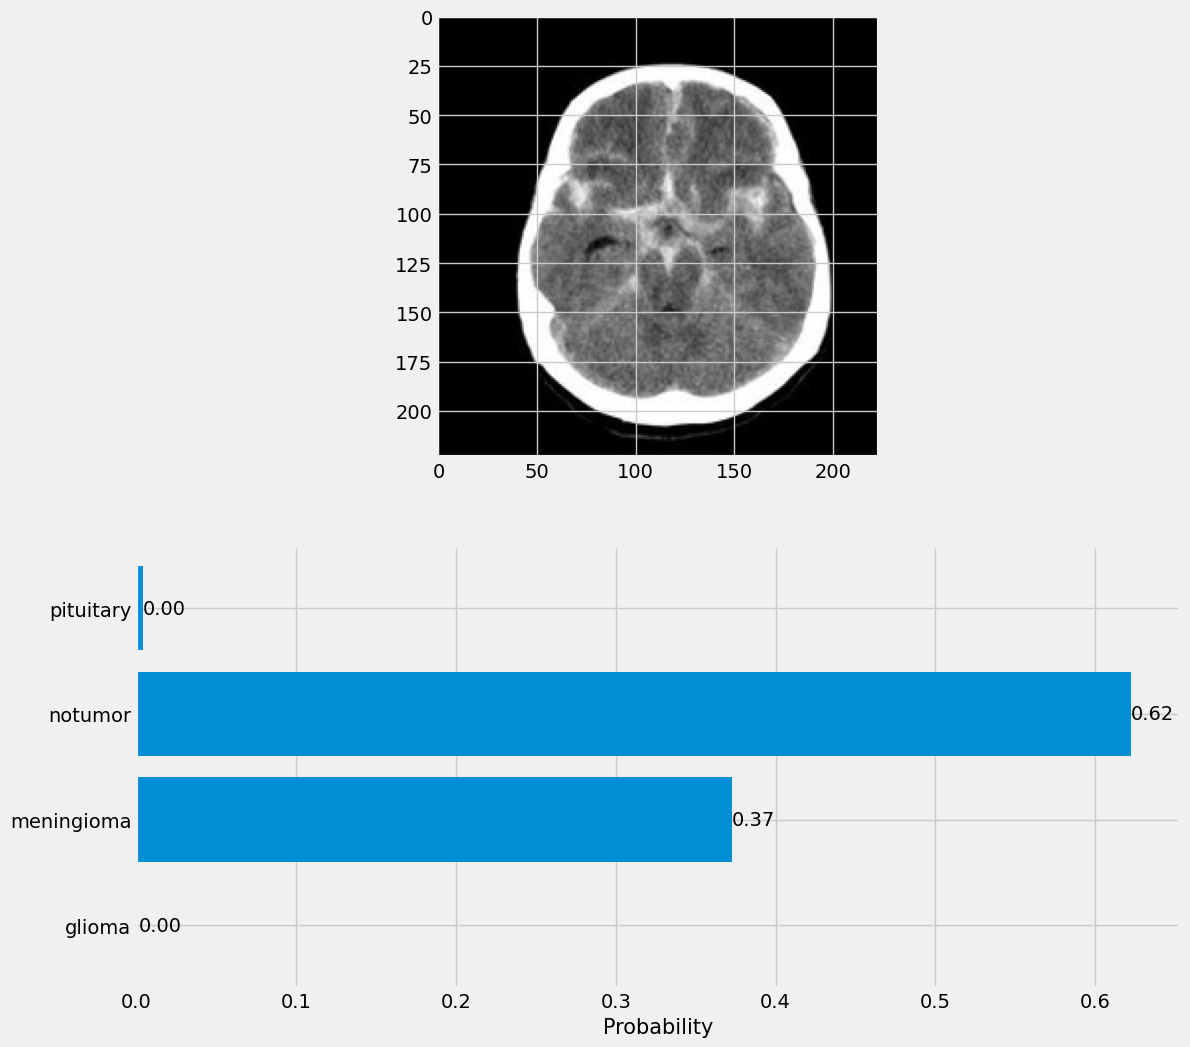

In [30]:
predict('/kaggle/input/Testing/notumor/Te-no_0011.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


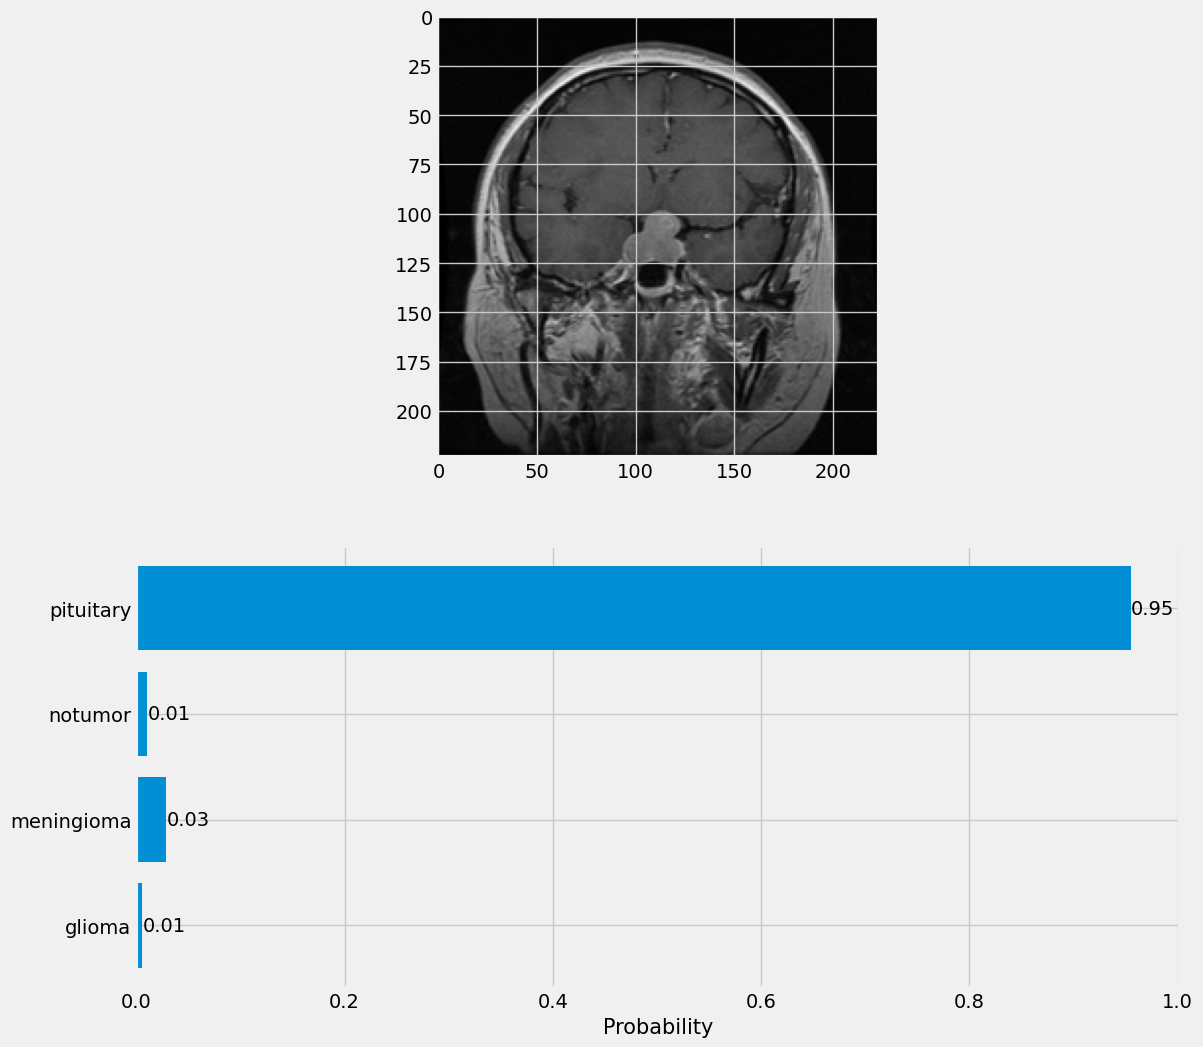

In [31]:
predict('/kaggle/input/Testing/pituitary/Te-piTr_0001.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


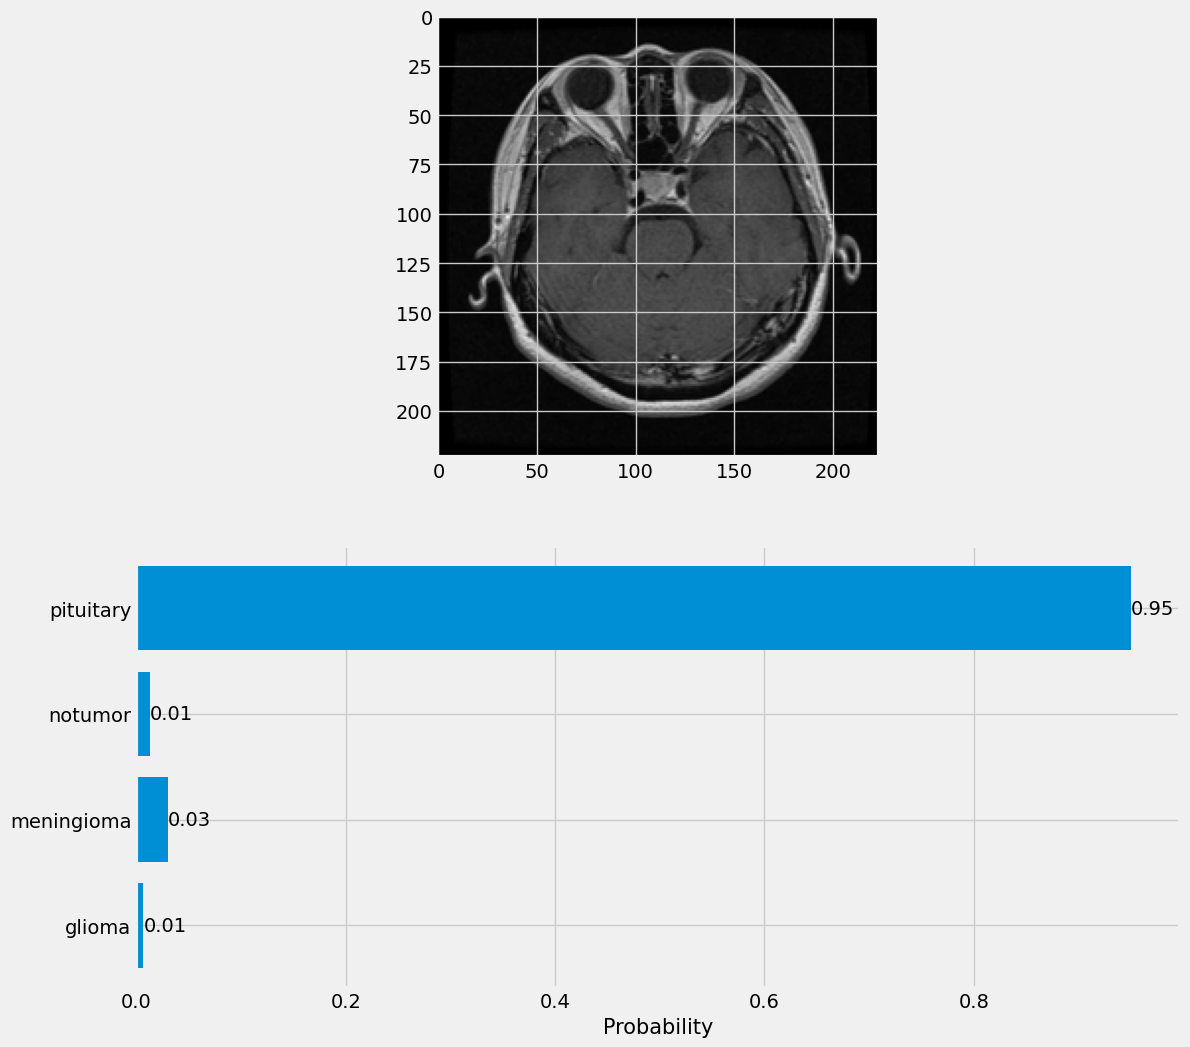

In [32]:
predict('/kaggle/input/Testing/pituitary/Te-pi_0011.jpg')